In [2]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')

import pickle, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multipolyfit as mpf
from scipy.interpolate import splrep,splev,UnivariateSpline
from numpy import random
from scipy import optimize, stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

%matplotlib inline

*data* is the output from CNN of the first frame of each video for training data

*test_data* is the output from CNN of the first frame of each video for validation data

*v_gt* is the ground truth as a dataframe, with following format:

VideoName | ValueAgreeableness | ValueConscientiousness | ValueExtraversion | ValueOpenness | ValueNeurotisicm
----------|---|---|---|---|---|
DrlC4bEYcmw.001.mp4 | 0.6915888 |0.6153846|0.5242718|0.6354167|0.5666667

*v_pred* is the predicted values of *v_gt*.

In [3]:
data = pickle.load(open( 'Raw_data6000.p', "rb" ))
test_data = pickle.load(open('Validation_data.p', "rb" ))
v_gt = pd.read_csv('validation_gt_full_name.csv')
v_pred = pd.read_csv('validation_predict.csv',delimiter='\t')

In [4]:
Xtrain = np.zeros((6000,1000))
y1train = np.zeros(6000)
y2train = np.zeros(6000)
y3train = np.zeros(6000)
y4train = np.zeros(6000)
y5train = np.zeros(6000)

Xtest = np.zeros((2000,1000))
y1test = np.zeros(2000)
y2test = np.zeros(2000)
y3test = np.zeros(2000)
y4test = np.zeros(2000)
y5test = np.zeros(2000)


idx = 0
for i in range(6000):
    key = data.keys()[i]
    
    Xtrain[idx,:] = data[key]['Raw']
    y1train[idx] = data[key]['O']
    y2train[idx] = data[key]['C']
    y3train[idx] = data[key]['E']
    y4train[idx] = data[key]['A']
    y5train[idx] = data[key]['N']
    
    idx += 1
    
idx = 0
for i in range(2000):
    key = v_gt.ix[i,0]
    
    Xtest[idx,:] = test_data[key]['Raw']
    y1test[idx] = test_data[key]['O']
    y2test[idx] = test_data[key]['C']
    y3test[idx] = test_data[key]['E']
    y4test[idx] = test_data[key]['A']
    y5test[idx] = test_data[key]['N']
    
    idx += 1

Regression

In [33]:
regr = RandomForestRegressor(n_estimators=125, criterion='mse', max_depth=100)

regr.fit(Xtrain, y1train.ravel())
y_1 = regr.predict(Xtest)
# regr.fit(Xtrain, y2train.ravel())
# y_2 = regr.predict(Xtest)
# regr.fit(Xtrain, y3train.ravel())
# y_3 = regr.predict(Xtest)
# regr.fit(Xtrain, y4train.ravel())
# y_4 = regr.predict(Xtest)
# regr.fit(Xtrain, y5train.ravel())
# y_5 = regr.predict(Xtest)

As regression was running abnormally, aka not on the line of expectation, normalize it. 

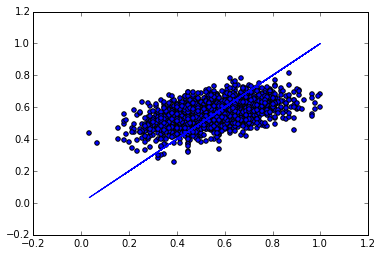

In [35]:
def matching_func(param, video_score, w_hat):
    return np.linalg.norm(video_score - param[0]*np.array(w_hat) - param[1])

def regularized_vector(video_score,w_hat):
    coeff = optimize.minimize(matching_func, [0, 0], args=(video_score, w_hat))

    a = coeff['x'][0]
    b = coeff['x'][1]
    v = a*np.array(w_hat)+b
    return v

reg_y_1 = regularized_vector(y1test,y_1)
plt.scatter(y1test,reg_y_1)
plt.plot(y1test,y1test)

print 'R^2 for trait %d is %.4f' % (1, r2(reg_y_1, y1test))

Compare to linear regression as baseline

In [31]:
regr_7 = Ridge(alpha=0.9)
regr_7.fit(Xtrain, y1train.ravel())
f_4 = regr_7.predict(Xtest)

slope, intercept, r_value, p_value, std_err = stats.linregress(f_4, y1test)
print r_value**2

0.159053181184


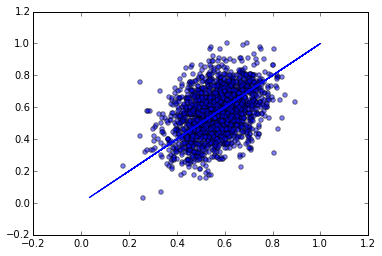

In [32]:
plt.scatter(f_4, y1test,alpha=0.5)
plt.plot(y1test,y1test)

In [125]:
raw_prediction = dict()
raw_prediction['y1'] = y1test
raw_prediction['p1'] = y_1
raw_prediction['y2'] = y2test
raw_prediction['p2'] = y_2
raw_prediction['y3'] = y3test
raw_prediction['p3'] = y_3
raw_prediction['y4'] = y4test
raw_prediction['p4'] = y_4
raw_prediction['y5'] = y5test
raw_prediction['p5'] = y_5
pickle.dump( raw_prediction , open('results.p', "wb" ) )


df = pd.read_csv('validation_gt_full_name.csv')

for i in range(df.shape[0]):
    df.ix[i,['ValueExtraversion',
             'ValueAgreeableness',
             'ValueConscientiousness',
             'ValueNeurotisicm',
             'ValueOpenness']] = [y_3[i],y_4[i],y_2[i],y_5[i],y_1[i]]
df.to_csv('validation_predict.csv', sep='\t')

Various error metrics

In [100]:
print 'Mean Square Error for trait %d is %.4f' % (1, mean_squared_error(y_1, y1test))
print 'Mean Square Error for trait %d is %.4f' % (2, mean_squared_error(y_2, y2test))
print 'Mean Square Error for trait %d is %.4f' % (3, mean_squared_error(y_3, y3test))
print 'Mean Square Error for trait %d is %.4f' % (4, mean_squared_error(y_4, y4test))
print 'Mean Square Error for trait %d is %.4f' % (5, mean_squared_error(y_5, y5test))

Mean Square Error for trait 1 is 0.0243
Mean Square Error for trait 2 is 0.0295
Mean Square Error for trait 3 is 0.0251
Mean Square Error for trait 4 is 0.0189
Mean Square Error for trait 5 is 0.0259


In [132]:
def r2(y, y_hat):
    slope, intercept, r_value, p_value, std_err = stats.linregress(y+0.0001, y_hat+0.00001)
    return r_value**2

print 'R^2 for trait %d is %.4f' % (1, r2(y_1, y1test))
print 'R^2 for trait %d is %.4f' % (2, r2(y_2, y2test))
print 'R^2 for trait %d is %.4f' % (3, r2(y_3, y3test))
print 'R^2 for trait %d is %.4f' % (4, r2(y_4, y4test))
print 'R^2 for trait %d is %.4f' % (5, r2(y_5, y5test))

R^2 for trait 1 is 0.2090
R^2 for trait 2 is 0.2766
R^2 for trait 3 is 0.2308
R^2 for trait 4 is 0.1362
R^2 for trait 5 is 0.2017


In [148]:
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y1test=raw_prediction['y1']
y_1=raw_prediction['p1']
y2test=raw_prediction['y2'] 
y_2=raw_prediction['p2']
y3test=raw_prediction['y3'] 
y_3=raw_prediction['p3']
y4test=raw_prediction['y4'] 
y_4=raw_prediction['p4'] 
y5test=raw_prediction['y5'] 
y_5=raw_prediction['p5'] 

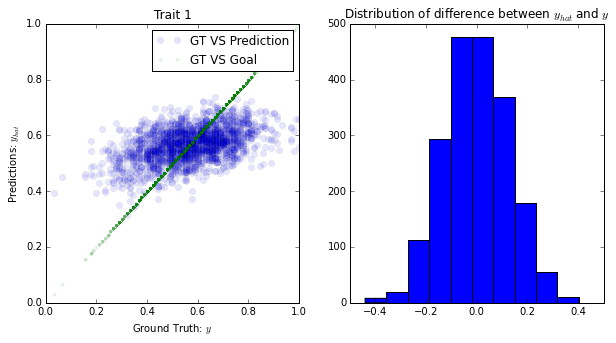

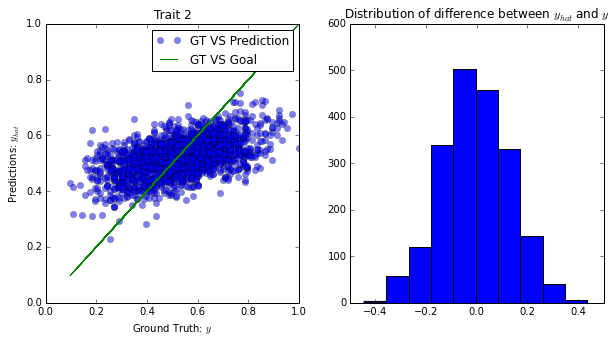

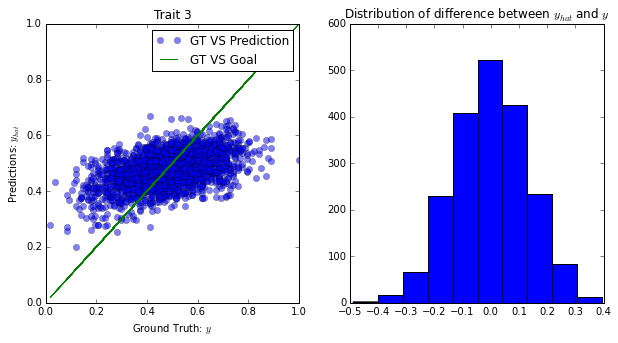

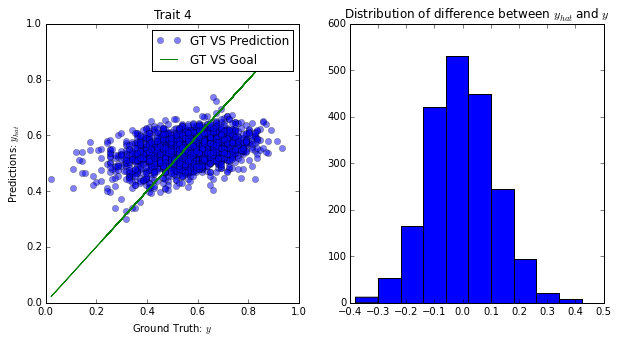

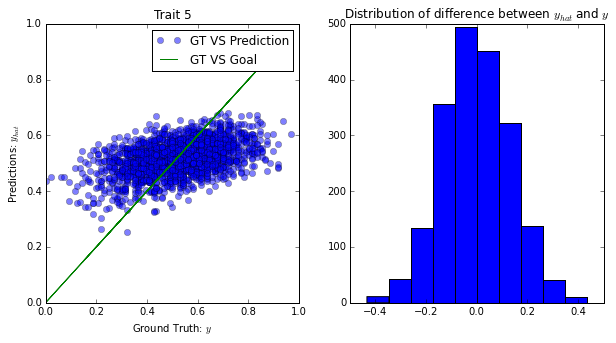

In [308]:
plt.figure(figsize=(10,5))
plt.subplot(121)    
plt.plot(y1test, y_1,'o',alpha=0.1)
plt.plot(y1test,y1test,'.',alpha=0.1)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Trait 1')
plt.xlabel('Ground Truth: $y$')
plt.ylabel('Predictions: $y_{hat}$')
plt.legend(['GT VS Prediction','GT VS Goal'])
plt.subplot(122)
plt.hist(y_1-y1test)
plt.title('Distribution of difference between $y_{hat}$ and $y$')

plt.figure(figsize=(10,5))
plt.subplot(121)    
plt.plot(y2test, y_2,'o',alpha=0.5)
plt.plot(y2test,y2test)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Trait 2')
plt.xlabel('Ground Truth: $y$')
plt.ylabel('Predictions: $y_{hat}$')
plt.legend(['GT VS Prediction','GT VS Goal'])
plt.subplot(122)
plt.hist(y_2-y2test)
plt.title('Distribution of difference between $y_{hat}$ and $y$')

plt.figure(figsize=(10,5))
plt.subplot(121) 
plt.plot(y3test, y_3,'o',alpha=0.5)
plt.plot(y3test,y3test)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Trait 3')
plt.xlabel('Ground Truth: $y$')
plt.ylabel('Predictions: $y_{hat}$')
plt.legend(['GT VS Prediction','GT VS Goal'])
plt.subplot(122)
plt.hist(y_3-y3test)
plt.title('Distribution of difference between $y_{hat}$ and $y$')

plt.figure(figsize=(10,5))
plt.subplot(121) 
plt.plot(y4test, y_4,'o',alpha=0.5)
plt.plot(y4test,y4test)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Trait 4')
plt.xlabel('Ground Truth: $y$')
plt.ylabel('Predictions: $y_{hat}$')
plt.legend(['GT VS Prediction','GT VS Goal'])
plt.subplot(122)
plt.hist(y_4-y4test)
plt.title('Distribution of difference between $y_{hat}$ and $y$')

plt.figure(figsize=(10,5))
plt.subplot(121) 
plt.plot(y5test, y_5,'o',alpha=0.5)
plt.plot(y5test,y5test)
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('Trait 5')
plt.xlabel('Ground Truth: $y$')
plt.ylabel('Predictions: $y_{hat}$')
plt.legend(['GT VS Prediction','GT VS Goal'])
plt.subplot(122)
plt.hist(y_5-y5test)
plt.title('Distribution of difference between $y_{hat}$ and $y$')

In [283]:
raw_prediction = pickle.load(open( 'results.p', "rb" ))

rand=False

y1test=raw_prediction['y1']
y_1=raw_prediction['p1']

y2test=raw_prediction['y2'] 
y_2=raw_prediction['p2']

y3test=raw_prediction['y3'] 
y_3=raw_prediction['p3']

y4test=raw_prediction['y4'] 
y_4=raw_prediction['p4'] 

y5test=raw_prediction['y5'] 
y_5=raw_prediction['p5']

if rand == True:
    np.random.shuffle(y_1)
    np.random.shuffle(y_2)
    np.random.shuffle(y_3)
    np.random.shuffle(y_4)
    np.random.shuffle(y_5)

print np.mean(np.abs(y1test-np.mean(y1test)))
print np.mean(np.abs(y2test-np.mean(y2test)))
print np.mean(np.abs(y3test-np.mean(y3test)))
print np.mean(np.abs(y4test-np.mean(y4test)))
print np.mean(np.abs(y5test-np.mean(y5test)))


# print np.mean([(y_1[i]-y1test[i])**2 for i in range(len(y_1))])
# print np.mean([(y_2[i]-y2test[i])**2 for i in range(len(y_1))])
# print np.mean([(y_3[i]-y3test[i])**2 for i in range(len(y_1))])
# print np.mean([(y_4[i]-y4test[i])**2 for i in range(len(y_1))])
# print np.mean([(y_5[i]-y5test[i])**2 for i in range(len(y_1))])

# print

# print np.sqrt(np.mean([(y_1[i]-y1test[i])**2 for i in range(len(y_1))]))
# print np.sqrt(np.mean([(y_2[i]-y2test[i])**2 for i in range(len(y_1))]))
# print np.sqrt(np.mean([(y_3[i]-y3test[i])**2 for i in range(len(y_1))]))
# print np.sqrt(np.mean([(y_4[i]-y4test[i])**2 for i in range(len(y_1))]))
# print np.sqrt(np.mean([(y_5[i]-y5test[i])**2 for i in range(len(y_1))]))

# print np.std(y1test)
# print np.std(y2test)
# print np.std(y3test)
# print np.std(y4test)
# print np.std(y5test)

0.115340377778
0.125943106796
0.119413168224
0.100825862638
0.1209515625


Cells below was used to calculate $R^2$ of GT, Prediction and their randomized values combination

In [139]:
gt = y1test
pred = y_1
print 'R^2 for trait %d is %.4f' % (1, r2(gt, pred))
gt_shuffled = y1test
np.random.shuffle(gt_shuffled)
print 'R^2 for trait %d is %.4f' % (1, r2(gt_shuffled, pred))
pred_shuffled = y_1
np.random.shuffle(pred_shuffled)
print 'R^2 for trait %d is %.4f' % (1, r2(gt_shuffled, pred_shuffled))
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y1test=raw_prediction['y1']
gt = y1test
print 'R^2 for trait %d is %.4f' % (1, r2(gt, pred_shuffled))

R^2 for trait 1 is 0.2090
R^2 for trait 1 is 0.0000
R^2 for trait 1 is 0.0001
R^2 for trait 1 is 0.0023


In [144]:
gt = y2test
pred = y_2
print 'R^2 for trait %d is %.4f' % (2, r2(gt, pred))
gt_shuffled = y2test
np.random.shuffle(gt_shuffled)
print 'R^2 for trait %d is %.4f' % (2, r2(gt_shuffled, pred))
pred_shuffled = y_2
np.random.shuffle(pred_shuffled)
print 'R^2 for trait %d is %.4f' % (2, r2(gt_shuffled, pred_shuffled))
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y2test=raw_prediction['y2']
gt = y2test
print 'R^2 for trait %d is %.4f' % (2, r2(gt, pred_shuffled))

R^2 for trait 2 is 0.2766
R^2 for trait 2 is 0.0013
R^2 for trait 2 is 0.0001
R^2 for trait 2 is 0.0002


In [145]:
gt = y3test
pred = y_3
print 'R^2 for trait %d is %.4f' % (3, r2(gt, pred))
gt_shuffled = y3test
np.random.shuffle(gt_shuffled)
print 'R^2 for trait %d is %.4f' % (3, r2(gt_shuffled, pred))
pred_shuffled = y_3
np.random.shuffle(pred_shuffled)
print 'R^2 for trait %d is %.4f' % (3, r2(gt_shuffled, pred_shuffled))
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y3test=raw_prediction['y3']
gt = y3test
print 'R^2 for trait %d is %.4f' % (3, r2(gt, pred_shuffled))

R^2 for trait 3 is 0.2308
R^2 for trait 3 is 0.0006
R^2 for trait 3 is 0.0000
R^2 for trait 3 is 0.0020


In [146]:
gt = y4test
pred = y_4
print 'R^2 for trait %d is %.4f' % (4, r2(gt, pred))
gt_shuffled = y4test
np.random.shuffle(gt_shuffled)
print 'R^2 for trait %d is %.4f' % (4, r2(gt_shuffled, pred))
pred_shuffled = y_4
np.random.shuffle(pred_shuffled)
print 'R^2 for trait %d is %.4f' % (4, r2(gt_shuffled, pred_shuffled))
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y4test=raw_prediction['y4']
gt = y4test
print 'R^2 for trait %d is %.4f' % (4, r2(gt, pred_shuffled))

R^2 for trait 4 is 0.1362
R^2 for trait 4 is 0.0002
R^2 for trait 4 is 0.0008
R^2 for trait 4 is 0.0000


In [147]:
gt = y5test
pred = y_5
print 'R^2 for trait %d is %.4f' % (5, r2(gt, pred))
gt_shuffled = y5test
np.random.shuffle(gt_shuffled)
print 'R^2 for trait %d is %.4f' % (5, r2(gt_shuffled, pred))
pred_shuffled = y_5
np.random.shuffle(pred_shuffled)
print 'R^2 for trait %d is %.4f' % (5, r2(gt_shuffled, pred_shuffled))
raw_prediction = pickle.load(open( 'results.p', "rb" ))
y5test=raw_prediction['y5']
gt = y5test
print 'R^2 for trait %d is %.4f' % (5, r2(gt, pred_shuffled))

R^2 for trait 5 is 0.2017
R^2 for trait 5 is 0.0000
R^2 for trait 5 is 0.0000
R^2 for trait 5 is 0.0009


# This section below test the extreme values:
I suggested previously that you create a dataset of extreme cases (with clear-cut scores).
We need those to debug. We need to visualize them and check they make sense. We need to make a test set out of them, train on the rest, then test on them. If we don’t get high accuracy, we are in trouble.

In [220]:
print 'Original Ground Truth Data'
v_gt.ix[0:3]

Original Ground Truth Data


,VideoName,ValueExtraversion,ValueAgreeableness,ValueConscientiousness,ValueNeurotisicm,ValueOpenness
0,DrlC4bEYcmw.001.mp4,0.691589,0.615385,0.524272,0.635417,0.566667
1,o7rFDFvW300.000.mp4,0.401869,0.439560,0.320388,0.406250,0.555556
2,Wx_oe0SxD9w.004.mp4,0.485981,0.670330,0.601942,0.625000,0.577778
3,d4cPiUXpGbc.004.mp4,0.523364,0.593407,0.543689,0.520833,0.566667


In [221]:
# Extracting the largest 100 values

largest_O = np.array((v_gt.ix[:,'ValueOpenness'].values).tolist()).argsort()[-100:][::-1]
largest_C = np.array((v_gt.ix[:,'ValueConscientiousness'].values).tolist()).argsort()[-100:][::-1]
largest_E = np.array((v_gt.ix[:,'ValueExtraversion'].values).tolist()).argsort()[-100:][::-1]
largest_A = np.array((v_gt.ix[:,'ValueAgreeableness'].values).tolist()).argsort()[-100:][::-1]
largest_N = np.array((v_gt.ix[:,'ValueNeurotisicm'].values).tolist()).argsort()[-100:][::-1]

In [272]:
train_O_idx = [i for i in range(2000) if i not in largest_O]
train_O = v_gt.ix[train_O_idx,:]
test_O = v_gt.ix[largest_O,:]

In [273]:
Xtrain_O = np.zeros((1900,1000))
ytrain_O = np.zeros(1900)

Xtest_O = np.zeros((100,1000))
ytest_O = np.zeros(100)


idx = 0
for i in range(1900):
    key = np.array((train_O.ix[:,'VideoName'].values).tolist())[i]
    
    Xtrain_O[idx,:] = test_data[key]['Raw']
    ytrain_O[idx] = test_data[key]['O']
    
    idx += 1
    
idx = 0
for i in range(100):
    key = np.array((test_O.ix[:,'VideoName'].values).tolist())[i]
    
    Xtest_O[idx,:] = test_data[key]['Raw']
    ytest_O[idx] = test_data[key]['O']

    idx += 1


regr = RandomForestRegressor(n_estimators=25, criterion='mse', max_depth=25)

regr.fit(Xtrain_O, ytrain_O.ravel())
y_O = regr.predict(Xtest_O)

In [274]:
r2(y_O, ytest_O)

0.032970078562535338

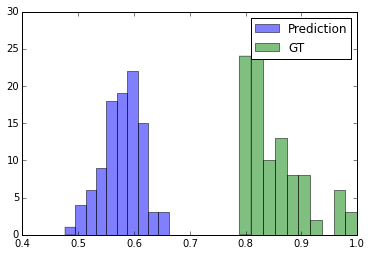

In [275]:
plt.hist(y_O,alpha=0.5)
plt.hist(ytest_O,alpha=0.5)
plt.legend(['Prediction','GT'])

In [276]:
train_C_idx = [i for i in range(2000) if i not in largest_C]
train_C = v_gt.ix[train_C_idx,:]
test_C = v_gt.ix[largest_C,:]

In [279]:
Xtrain_C = np.zeros((1900,1000))
ytrain_C = np.zeros(1900)

Xtest_C = np.zeros((100,1000))
ytest_C = np.zeros(100)


idx = 0
for i in range(1900):
    key = np.array((train_C.ix[:,'VideoName'].values).tolist())[i]
    
    Xtrain_C[idx,:] = test_data[key]['Raw']
    ytrain_C[idx] = test_data[key]['C']
    
    idx += 1
    
idx = 0
for i in range(100):
    key = np.array((test_C.ix[:,'VideoName'].values).tolist())[i]
    
    Xtest_C[idx,:] = test_data[key]['Raw']
    ytest_O[idx] = test_data[key]['C']

    idx += 1


regr = RandomForestRegressor(n_estimators=25, criterion='mse', max_depth=25)

regr.fit(Xtrain_C, ytrain_C.ravel())
y_C = regr.predict(Xtest_C)

0.0


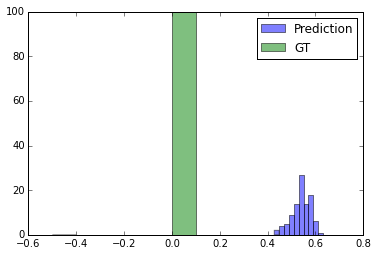

In [280]:
print r2(y_C, ytest_C)
plt.hist(y_C,alpha=0.5)
plt.hist(ytest_C,alpha=0.5)
plt.legend(['Prediction','GT'])

# Below is the part with MFCC

In [ ]:
pkl_file = open('./MFCC/training_fbank.mfcc', 'rb') 
mfccFile = pickle.load(pkl_file)
pkl_file.close()